# Prepare Environment

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import display

import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
%matplotlib inline

# Prepare Food Classification Dataset

This section contains the steps to prepare our own dataset. Here we will create a dataset for food classification.

## Download Images from the Internet

We start from downloading images from the Internet. In this exercise, we only focus on FIVE types of food.

For example,

*   Pad Thai (ผัดไทย)
*   Chicken Rice (ข้าวมันไก่)
*   Green Curry (แกงเขียวหวาน)
*   Noodle (ก๋วยเตี๋ยวเรือ)
*   Basil pork with rice (ข้าวผัดกระเพรา)

Make sure that you have at least 10 images for each food type. This allows us to have at least 50 images to training a model for simple food classification.

Here we create a dictionary that can be used to convert from the class number into text.

In [ ]:
class2text = {
    0: 'Pad Thai',
    1: 'Chicken Rice',
    2: 'Green Curry',
    3: 'Noodle',
    4: 'Basil pork with rice',
}

## Upload Images to Your Google Drive

Next we will upload the downloaded images into our Google Drive folder. You may create a new folder, named `food_dataset` and then uploaded the images into such folder.

## Create a Google Spreadsheet Containing a List of Images and Their Classes

Next we will create a Google Spreadsheet, consisting of TWO columns:

1.   `filename`: specify the filename of an image
2.   `class`: specify the class of an image (i.e., food type in this example)



## Mount Google Drive to Google Colab

Next we will connect our Google Colab to the `food_dataset` folder in Google Drive. This allows us to read/write files to/from the Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then we specify the path to our `food_dataset` folder in Google Drive. If you created the `food_dataset` folder under `My Drive` folder. You can use the following path:

`data_dir = '/content/drive/My Drive/food_dataset'`

In [ ]:
# e.g., data_dir = '/content/drive/My Drive/food_dataset'
data_dir = '/content/drive/My Drive/food_dataset'
num_classes = 5

You can use the following code to verify that you can reach the `food_dataset` folder from Google Colab. You should see the list of images, `train_dataset.csv` and `test_dataset.csv`.

In [ ]:
!ls

drive  sample_data


# Load Food Classification Dataset

This section contains scripts to load the annotated (or labelled) images from the `food_dataset` folder. These data will used to train a model for food classification.

## Load Annotated Images

Here we define the function used to load the dataset.

In [ ]:
from tensorflow.keras.preprocessing import image

def load_dataset(data_df):
    '''Function to load dataset.'''
    x = []
    y = []
    for i, r in data_df.iterrows():
        f = os.path.join(data_dir, r['filename'])   # filename
        c = r['class']                              # class

        # Load and resize the image
        img = image.load_img(f, target_size=(224, 224))

        # Convert the Image object into a numpy array
        img = image.img_to_array(img)

        # Add to a list of images and classes
        x.append(img)
        y.append(c)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

Next, we use the `load_dataset` function to load the training and test sets, according to the specification from `train_dataset.csv` and `test_dataset.csv`.

In [ ]:
# Training set
train_df = pd.read_csv(os.path.join(data_dir, 'train_dataset.csv'))
raw_train_x, raw_train_y = load_dataset(train_df)

# Test set
test_df = pd.read_csv(os.path.join(data_dir, 'test_dataset.csv'))
raw_test_x, raw_test_y = load_dataset(test_df)

## Preprocessing

Next, we preprocess the data such that they can be used to train a model.

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

# Preprocess the input array
train_x = preprocess_input(raw_train_x)
test_x = preprocess_input(raw_test_x)

# Convert class data to one-hot format
train_y = to_categorical(raw_train_y, num_classes)
test_y = to_categorical(raw_test_y, num_classes)

# Convert the preprocessing images into `float32`
train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)

# Convert the one-hot vector into `int`
train_y = train_y.astype(np.int_)
test_y = test_y.astype(np.int_)

print(f'Training Set: {train_x.shape}, {train_y.shape}')
print(f'Test Set: {test_x.shape}, {test_y.shape}')

Training Set: (40, 224, 224, 3), (40, 5)
Test Set: (10, 224, 224, 3), (10, 5)


# Transfer Learning

This section contains the steps to load the pretrained model, which is `MobileNetV2` in this example, and then replace to top layers with a new ones for food classification.

## Adjust the Existing Model for Food Classification

First we need to load the existing `MobileNetV2` model, without the top layers.

In [ ]:
import tensorflow.keras
from keras.applications.mobilenet_v2 import MobileNetV2

# Create the base pre-trained model
# Note: include_top=False --> do not include the top layers
#       This allows us to replace the top with new layers for transfer learning
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',  #ถ้าเอา comment นี้ออก คือการใช้ weight ของ model ที่ให้มา
    #weights=None,      #ถ้าเอา comment นี้ออก คือการเทรนเอง ไม่ได้ใช้ weight ของ model ที่ให้มา
    include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Next we add new top layers that will classify the input images into five types of food.

In [ ]:
from keras.models import Sequential
from keras.layers import *

model = Sequential()

# Start with the base_model
model.add(base_model)

# Add a global spatial average pooling layer
model.add(GlobalAveragePooling2D())

# model.add()

# A fully-connected layer
model.add(Dense(1024, activation='relu'))

# A softmax layer -- note that we have 5 classes
model.add(Dense(num_classes, activation='softmax'))

Here we print the list of newly added layers in the model.

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 mobilenetv2_1.00_224
1 global_average_pooling2d
2 dense
3 dense_1


## Training Only Top Layers

Before we start fine-tuning the model, it is a common practice to first train only the newly added layers at the top of the model. This is because the top layers are *randomly initialized*, which may not work well with the currrent parameters of the pretrained model. We need to train the top layers to make it compatible with the features extracted from the layers below.

First, we train only the top layers by making all of the layers from `base_model` (i.e., MobileNetV2) not trainable.

In [ ]:
# Freeze all layers in the MobileNetV2, except the ones we have just added.
for layer in base_model.layers:
    layer.trainable = False  #ปรับ Gradient เฉพาะ Layer ใหม่ อันอื่นคงเดิม

Next, we configure the model for training.

In [ ]:
epochs = 20
batch_size = 16
learning_rate = 0.01

# SGD optimizer (you can use others)
optimizer = tensorflow.keras.optimizers.SGD(learning_rate)

# Cross-entropy loss
loss = tensorflow.keras.losses.categorical_crossentropy

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'])

Let's start feeding the data to train the model and it will learn to classify food images.

In [ ]:
hist = model.fit(
    train_x, train_y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2625 - loss: 1.7052
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6141 - loss: 1.2093
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8297 - loss: 0.8750
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9594 - loss: 0.6617
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9797 - loss: 0.5243
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.3979
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.3420
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.2856
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.2500
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.2086
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.2081
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1680
Ep

Here, we evaluate on the test images.

In [ ]:
score = model.evaluate(x=test_x, y=test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.39628511667251587
Test accuracy: 1.0


## Fine-tuning Model

At this point, the top layers are well trained and we can start fine-tuning other layers from `MobileNetV2`.

Let's visualize layer names and layer indices to see how many layers we should freeze.

In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_layer
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu


We can choose to freeze the bottom layers and train the remaining top layers, or finetune the entire model. The hyperparameter `n_freezes` in the script below is used to **control how many layers from the MobileNetV2 we would like to train**.

For example,

*   If we choose to train only the half blocks of the MobileNetV2 (i.e., freeze the first 82 layers and unfreeze the rest), we can set `n_freezes = 82`.
*   If we choose to train the entire model, we can set `n_freezes = 0`.

In [ ]:
n_freezes = 0

for layer in base_model.layers[:n_freezes]:
   layer.trainable = False
for layer in base_model.layers[n_freezes:]:
   layer.trainable = True

Next, we need to recompile the model for these modifications to take effect.

**Note**: During fine-tuning, it is a common practice to use a low learning rate.

In [ ]:
epochs = 20
batch_size = 16
learning_rate = 0.001

# We use SGD with a lower learning rate, compared to the training above
optimizer = tensorflow.keras.optimizers.SGD(learning_rate)

# Cross-entropy loss
loss = tensorflow.keras.losses.categorical_crossentropy

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'])

We train our model again (this time fine-tuning some layers in MobileNetV2 as well).

In [ ]:
hist = model.fit(
    train_x, train_y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - accuracy: 0.5359 - loss: 1.1980
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6469 - loss: 1.0202
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7375 - loss: 0.9421
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7531 - loss: 0.8621
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8906 - loss: 0.7323
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9187 - loss: 0.7048
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9141 - loss: 0.6760
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9750 - loss: 0.5906
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9797 - loss: 0.5139
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.4593
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.4314
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.4156
Ep

With the fine-tuning from the pretrained MobileNetV2, the performance on the test set should be better compared to starting from scratch.

In [ ]:
score = model.evaluate(x=test_x, y=test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3183620572090149
Test accuracy: 1.0


# Test on Newly Downloaded Images

In this section, we will use our model to test on the new images that we are going to download from the Internet.

## Upload Files

The `upload_files` function below can be used to upload files.

In [ ]:
from google.colab import files

def upload_files():
    uploaded = files.upload()
    for k, v in uploaded.items():
        open(k, 'wb').write(v)
    return list(uploaded.keys())

Run the following code block to upload your image files. This function returns a list of image paths which will be stored in `files`.

In [ ]:
files = upload_files()

Saving RackMultipart20190709-14929-w07169.jpg to RackMultipart20190709-14929-w07169.jpg


## Preprocessing

Before we can feed the images into the existing pretrained models, we need to preprocess such images into the format that such pretrained models have been trained on, which is `MobileNetV2` in this example.

[image RackMultipart20190709-14929-w07169.jpg]


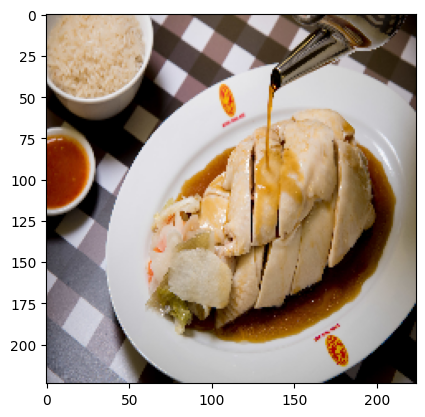

Image shape: (1, 224, 224, 3)


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

images = []
for f in files:
    # Load and resize the image
    img = image.load_img(f, target_size=(224, 224))

    # Convert the Image object into a numpy array
    img = image.img_to_array(img)

    # Add to a list of images
    images.append(img)

    # Visualize the resize image
    print(f'[image {f}]')
    plt.imshow(image.img_to_array(img).astype('uint8'))
    plt.show()
    plt.close("all")
images = np.asarray(images)

# Preprocess the input array
x = preprocess_input(images)

print(f"Image shape: {x.shape}")

## Classify Images

Then we use the finetuned `MobileNetV2` to determine the probabilities of food types that we defined.

In [ ]:
from keras.applications.mobilenet_v2 import decode_predictions

# Feed the preprocessed, downloaded image to the pretrained VGG-16.
# The outputs are the probabilities of classes defined in ImageNet.
probs = model.predict(x)

# Display the results
for i in range(len(files)):
    print(f'[image {files[i]}]')
    for c in range(num_classes):
        print(f'{class2text[c]} ({probs[i][c]*100:.2f}%)')
    print('')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[image RackMultipart20190709-14929-w07169.jpg]
Pad Thai (16.94%)
Chicken Rice (22.98%)
Green Curry (11.49%)
Noodle (4.09%)
Basil pork with rice (44.51%)

